# FINM 33150 Project Draft - Trading Volatility

Sean Lin (STUDENT ID) | Thomas McDonnell (STUDENT ID) | Ben Panovich (12365148) | Madison Rusch (12365298)

***

## 1 Introduction

In this notebook, we show the premise of what will become our quantitative trading strategy. As a quick summary, our trading strategy will involve capitalizing on volatility through the prediction of VIX. We will capitalize on this volatility by trading equity index options with a delta-hedged position in hopes to mitigate risk market directional risk. In addition, we will also trade other assets that move with volatility, notably futures, currencies, and bonds.

In [223]:
import os
import pandas as pd 
import numpy as np 
import functools 
import quandl 
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')

In [3]:
KEY = os.getenv('QUANDL_KEY')
quandl.ApiConfig.api_key = KEY # Insert your key here if you want to run the code yourself 

## 2 Data

For data, we'll be using a variety of data sources. More specifically, the majority of our price data will come from Quandl with historical options pricing data coming from Polygon. It's important to note that VIX price data isn't on Quandl and as a result, we obtained historical VIX data through CBOE's website. For prediction of VIX, we utilized the economic calendar, with data retrieved from [fxstreet.com](https://www.fxstreet.com/economic-calendar) and the Shanghai index, with data obtained from [investing.com](https://www.investing.com/indices/shanghai-composite). For some analysis, we also retrieved historical implied volatilities through the VOL Quandl database (though you may not have access if you haven't purchased the dataset). All the raw data is included with this notebook.

***

**2.1 Helper Functions**

We first define helper functions `fetch_quandl` and `fetch_quandl_table` to retrieve data from Quandl databases.

In [4]:
# TODO: Add documentation for function
@functools.lru_cache()
def fetch_quandl(asset, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      paginate=True)
    return qdata

In [5]:
# TODO: Add documentation for function
@functools.lru_cache()
def fetch_quandl_table(table, ticker, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      qopts = {"columns":["date", "adj_close", "adj_volume"]},
                      ticker = ticker,
                      paginate=True)
    qdata = qdata.set_index('date').sort_index(ascending=True)
    return qdata

***

**2.1 Importing Data**

Here, we will import the data needed for our predictions and analysis for our time period. We will first collect the data needed for predicting VIX.

In [6]:
START_DATE = '2014-01-01'
END_DATE = '2022-12-23'

We will first collect VIX data. This was taken from CBOE's website. 

In [7]:
filename = './data/vix_data.csv'
vix_data = pd.read_csv(filename)
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')[['CLOSE']]
vix_data = vix_data.loc[START_DATE:END_DATE]

We will now collect the economic calendar data. We obtain all the events considered *high importance* from FXStreet. In general, this consists of events like FOMC, CPI, Fed Chair Speeches, and Non-Farm Payroll.

In [17]:
filename = './data/economic_calendar.csv'
event_data = pd.read_csv(filename)
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

When considering days until an event, we want to consider the weekends as options pricing uses a full calendar year, not trading years (i.e theta decay applies over weekends). Thus, we want to calculate the time until an event (including weekends).

In [19]:
idx = vix_data.index
all_dates = pd.date_range(START_DATE,END_DATE)

temp = vix_data.copy()
temp.columns = ['VIX']
temp = temp.reindex(idx, fill_value=None)
temp['Event'] = np.where(temp.index.isin(event_data.index.values), True, False)
temp['Days until Event'] = np.where(temp['Event'] == True, 0, vix_data.groupby((temp['Event'] == True).cumsum()).cumcount(ascending=False)+1)
temp = temp.dropna(subset=['VIX'])
temp = temp[['VIX', 'Days until Event']]

We will now obtain SPY data. We only want to consider US trading days. In other words, we only want to look at dates where SPY has a close (even if it's an early close).

In [10]:
spy_data = fetch_quandl_table('QUOTEMEDIA/PRICES','SPY',begin_date=START_DATE,end_date=END_DATE)
spy_data.columns = ['SPY', 'SPY Volume']
trading_days = spy_data.index 
temp = temp.loc[temp.index.isin(trading_days)]

We will now import the Shanghai index data. This is used as the Shanghai Stock Exchange closes before the US Stock Exchange opens. This could potentially give us valuable information on the behavior of VIX during the next day as the global markets usually have some type of correlation.

In [360]:
filename = './data/ssec_data.csv'
ssec_data = pd.read_csv(filename)
ssec_data['Date'] = pd.to_datetime(ssec_data['Date'])
ssec_data = ssec_data.set_index('Date')
ssec_data = ssec_data.loc[ssec_data.index.isin(trading_days)].sort_index(ascending=True)
ssec_data = ssec_data[['Price']].rename(columns={'Price':'SSEC'})
ssec_data = ssec_data['SSEC'].str.replace(',','').astype(float).to_frame()

We'll now import Crude Oil futures data (CL). Since futures have quarterly expires, we will roll these over. 

In [86]:
securities = ['OWF/NYM_CL_CL']
dates = ['H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020', 'M2020', 'U2020', 'Z2020',
         'H2021', 'M2021', 'U2021', 'Z2021', 
         'H2022', 'M2022', 'U2022', 'Z2022',
         'H2023']

# Fetch NYM_RB_RB Data
finalized_data = pd.DataFrame()
security = securities[0]
trim_start = START_DATE
trim_end = END_DATE
for month in tqdm(dates):
  data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
  # data = clean_quandl_columns(data)
  # data = data[data['DtT'] > 30]
  if finalized_data.empty:
    finalized_data = data
  else:
    finalized_data = pd.concat([finalized_data, data])
  trim_start = finalized_data.index[-1] + pd.DateOffset(1)

cl_data = finalized_data.copy()[['Future']].rename(columns={'Future':'CL'})

100%|██████████| 37/37 [00:00<00:00, 5691.68it/s]


In [361]:
all_data = pd.concat([temp, spy_data, ssec_data, cl_data], axis=1)
display(all_data)

,VIX,Days until Event,SPY,SPY Volume,SSEC,CL
2014-01-02,14.23,1.0,154.868957,119636900.0,2109.39,95.62
2014-01-03,13.76,0.0,154.843559,81390600.0,2083.14,94.14
2014-01-06,13.55,0.0,154.394837,108028200.0,2045.71,93.58
2014-01-07,12.92,1.0,155.343079,86144200.0,2047.32,93.84
2014-01-08,12.87,0.0,155.376951,96582300.0,2044.34,92.53
...,...,...,...,...,...,...
2022-12-19,22.42,3.0,380.020000,79633670.0,3107.11,75.44
2022-12-20,21.48,2.0,380.540000,74167078.0,3073.77,76.23
2022-12-21,20.07,1.0,386.230000,77994406.0,3068.41,78.24
2022-12-22,21.97,0.0,380.720000,99890854.0,3054.43,77.42


In [362]:
all_data['VIX Returns'] = all_data['VIX'].pct_change()
all_data['SPY Returns'] = all_data['SPY'].pct_change()
all_data['SSEC Returns'] = all_data['SSEC'].pct_change()
all_data['CL Returns'] = all_data['CL'].pct_change()

predictors = all_data[['Days until Event','SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']].dropna()

In [368]:
predictors['VIX Returns (y)'] = predictors['VIX Returns'].shift(-1)
predictors['SSEC Returns'] = predictors['SSEC Returns'].shift(-1)
predictors = predictors.drop(columns=['VIX Returns'])

predictors = predictors.dropna()

# 3 Predicting VIX

In [370]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

In [396]:
START_TRAIN = '2014-01-01'
END_TRAIN = '2022-01-01'
START_TEST = END_TRAIN 
END_TEST = '2022-12-01'

arima_data = predictors.loc[START_TRAIN:END_TEST]
display(arima_data.head())

,Days until Event,SPY Volume,SPY Returns,SSEC Returns,CL Returns,VIX Returns (y)
2014-01-03,0.0,81390600.0,-0.000164,-0.001456,-0.015478,-0.015262
2014-01-06,0.0,108028200.0,-0.002898,-0.008179,-0.005949,-0.046494
2014-01-07,1.0,86144200.0,0.006142,-0.007062,0.002778,-0.003870
2014-01-08,0.0,96582300.0,0.000218,-0.001858,-0.013960,0.001554
2014-01-09,1.0,90683400.0,0.000654,0.008599,-0.006917,-0.058185


In [399]:
predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_TEST].index,columns=['predictions'])
start, end = 0, 252
for i in range(len(arima_data.loc[START_TEST:END_TEST])-1):
    model = ARIMA(arima_data.iloc[start:end]['VIX Returns (y)'], order=(1,1,1), exog=arima_data.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=arima_data.iloc[end+1,:5])
    start, end = start, end + 1 

    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()

In [400]:
predicted_results['actual'] = arima_data.loc[START_TEST:END_TEST,'VIX Returns (y)'][:-1]
predicted_results 

,predictions,actual
2022-01-03,-0.012374,0.018675
2022-01-04,0.16973,0.166765
2022-01-05,0.126037,-0.006082
2022-01-06,-0.11154,-0.043345
2022-01-07,-0.043213,0.034115
...,...,...
2022-11-23,0.026336,0.003918
2022-11-25,-0.017575,0.083415
2022-11-28,-0.05302,-0.014408
2022-11-29,0.051831,-0.059845


<AxesSubplot: >

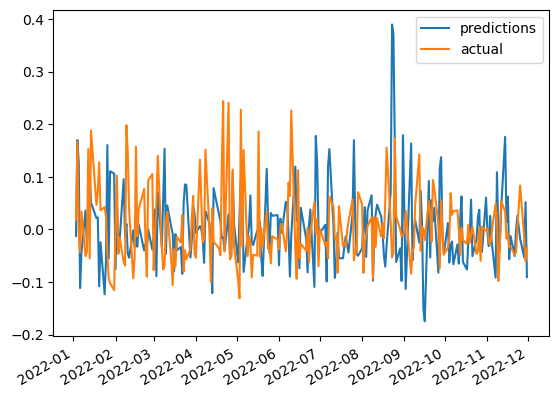

In [401]:
predicted_results.plot()

In [402]:
(np.sign(predicted_results['predictions']) == np.sign(predicted_results['actual'])).sum() / len(predicted_results)

0.49130434782608695

In [404]:
significant = predicted_results[predicted_results['actual'] > 0.05]

In [405]:
(np.sign(significant['predictions']) == np.sign(significant['actual'])).sum() / len(significant)

0.5348837209302325